# Diabetes Readmission Project: Data Exploration and Preprocessing

This project focuses on data from 130 US hospitals to predict early readmission in diabetic patients within 30 days. The project workflow includes:
1. Data Exploration and Clustering
2. Data Preprocessing and Feature Engineering
3. Algorithm Selection and Model Training
4. Result Analysis
5. Visualization
6. Web Integration


## Step 1: Importing Libraries

In [2]:
pip install dash flask plotly requests scikit-learn seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 38.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
import requests
from flask import Flask, request, jsonify
import dash
from dash import dcc, html
import plotly.express as px
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

Matplotlib is building the font cache; this may take a moment.


Inspecting the first few rows of the dataset:
   encounter_id  patient_nbr             race  gender      age weight  \
0       2278392      8222157        Caucasian  Female   [0-10)      ?   
1        149190     55629189        Caucasian  Female  [10-20)      ?   
2         64410     86047875  AfricanAmerican  Female  [20-30)      ?   
3        500364     82442376        Caucasian    Male  [30-40)      ?   
4         16680     42519267        Caucasian    Male  [40-50)      ?   

   admission_type_id  discharge_disposition_id  admission_source_id  \
0                  6                        25                    1   
1                  1                         1                    7   
2                  1                         1                    7   
3                  1                         1                    7   
4                  1                         1                    7   

   time_in_hospital  ... citoglipton insulin  glyburide-metformin  \
0                 1

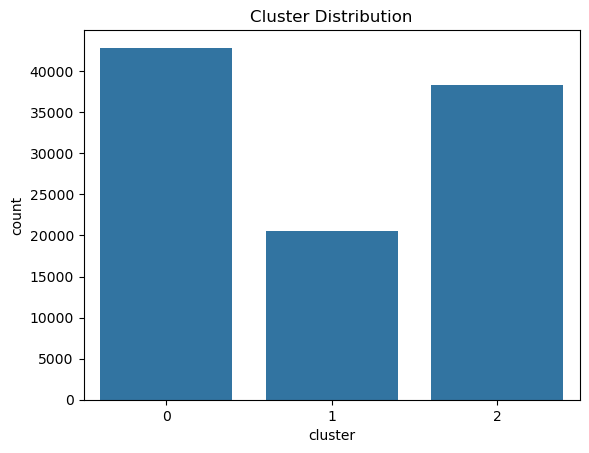


Class distribution in the 'readmitted' column:
NO     54864
>30    35545
<30    11357
Name: readmitted, dtype: int64


In [11]:
# Loading datasets
diabetic_data = pd.read_csv('diabetic_data.csv')
ids_mapping = pd.read_csv('IDS_mapping.csv')

# Inspecting the first few rows of the dataset to check data integrity
print("Inspecting the first few rows of the dataset:")
print(diabetic_data.head())  # Display the first few rows

# Initial exploration
print("Diabetic Data Shape:", diabetic_data.shape)
print("Missing Values Count:\n", diabetic_data.isnull().sum())
print("Data Types:\n", diabetic_data.dtypes)

# Basic statistics
print("Basic Statistics:\n", diabetic_data.describe(include='all'))

# Clustering analysis to identify patient segments
# Replace '?' placeholders, and perform KMeans clustering on numeric data only
diabetic_data.replace('?', np.nan, inplace=True)
numeric_data = diabetic_data.select_dtypes(include=[np.number]).fillna(0)
kmeans = KMeans(n_clusters=3, random_state=42)
diabetic_data['cluster'] = kmeans.fit_predict(numeric_data)

# Visualizing clusters
sns.countplot(data=diabetic_data, x='cluster')
plt.title("Cluster Distribution")
plt.show()

# Checking for class imbalance in the target variable 'readmitted'
print("\nClass distribution in the 'readmitted' column:")
print(diabetic_data['readmitted'].value_counts())

## Step 2: Data Preprocessing & Feature Engineering

Handling missing values, mapping categorical IDs, encoding features, and creating additional useful features.

## Replacing Placeholders (`?`) with `NaN`

Replacing any placeholders (`?`) in the dataset with `NaN` to ensure they are accurately recognized as missing values.

In [8]:
# Step: Replace '?' placeholders with NaN to standardize missing values
print("Replacing '?' placeholders with NaN...")

# Replacing placeholders
diabetic_data.replace('?', np.nan, inplace=True)

# Checking for columns with missing values
missing_counts = diabetic_data.isnull().sum()
missing_counts = missing_counts[missing_counts > 0]  # Filter columns with missing values only

# Printing results of replacement
if missing_counts.empty:
    print("No missing values were found after replacement.")
else:
    print("Missing values were identified in the following columns after replacing placeholders:")
    print(missing_counts)

# Summary
print(f"\nTotal columns with missing values: {len(missing_counts)}")
print("Missing values replacement and reporting completed.\n")

Replacing '?' placeholders with NaN...
Missing values were identified in the following columns after replacing placeholders:
race                  2273
weight               98569
payer_code           40256
medical_specialty    49949
diag_1                  21
diag_2                 358
diag_3                1423
dtype: int64

Total columns with missing values: 7
Missing values replacement and reporting completed.



## Step 3: Handling Missing Values

After identifying the columns with missing values, we need to address these gaps. We'll handle each column based on the type of data and the proportion of missing entries:

1. **High missingness (e.g., `weight`)**: Considering dropping if the column has more than 90% missing values.
2. **Categorical Columns (e.g., `race`, `payer_code`, `medical_specialty`)**: Imputing with the most frequent (mode) value.
3. **Diagnostic Codes (e.g., `diag_1`, `diag_2`, `diag_3`)**: Imputing with the most frequent value or consider grouping similar diagnoses.

In [10]:
# Dropping 'weight' column due to high missingness (over 90% missing)
if 'weight' in diabetic_data.columns:
    diabetic_data.drop(columns=['weight'], inplace=True)
    print("Dropped 'weight' column due to high proportion of missing values.")

# Imputing categorical columns with the most frequent (mode) value
categorical_columns_to_impute = ['race', 'payer_code', 'medical_specialty']
for column in categorical_columns_to_impute:
    mode_value = diabetic_data[column].mode()[0]
    diabetic_data[column].fillna(mode_value, inplace=True)
    print(f"Filled missing values in '{column}' with the most frequent value: {mode_value}")

# Imputing diagnosis codes with the most frequent value
diagnosis_columns = ['diag_1', 'diag_2', 'diag_3']
for column in diagnosis_columns:
    mode_value = diabetic_data[column].mode()[0]
    diabetic_data[column].fillna(mode_value, inplace=True)
    print(f"Filled missing values in '{column}' with the most frequent value: {mode_value}")

# Verifying that there are no remaining missing values
remaining_missing = diabetic_data.isnull().sum().sum()
if remaining_missing == 0:
    print("\nAll the missing values have been successfully handled.")
else:
    print(f"\nWarning: {remaining_missing} missing values remain in the dataset. Consider doing something about it.")

Filled missing values in 'race' with the most frequent value: Caucasian
Filled missing values in 'payer_code' with the most frequent value: MC
Filled missing values in 'medical_specialty' with the most frequent value: InternalMedicine
Filled missing values in 'diag_1' with the most frequent value: 428
Filled missing values in 'diag_2' with the most frequent value: 276
Filled missing values in 'diag_3' with the most frequent value: 250

All the missing values have been successfully handled.
